# Heart Failure Prediction - Clinical Records 🏥


<img src="https://storage.googleapis.com/kaggle-datasets-images/4941995/8320058/72f3198655e9d81f21bcbb56c974d2de/dataset-cover.jpg?t=2024-05-05-08-21-46" width="20%">


The dataset used in this analysis can be downloaded from the following URL: https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records

Date of data download: 02/06/2024

Attribute Information:
- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **creatinine phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **high blood pressure**: if the patient has hypertension (boolean)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **DEATH_EVENT**: if the patient died during the follow-up period (boolean)

## 0 - Initialization <a class="anchor" id="initialization-header"></a>

In [87]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from utils import matplotlib_config

# Get the list of the custom palette defined
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Load the dataset
df = pd.read_csv('heart_failure_clinical_records.csv')
# Display the first 5 rows of the dataset
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [93]:
# Print the shape of the dataset
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (5000, 13)


In [3]:
# Print the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       5000 non-null   float64
 1   anaemia                   5000 non-null   int64  
 2   creatinine_phosphokinase  5000 non-null   int64  
 3   diabetes                  5000 non-null   int64  
 4   ejection_fraction         5000 non-null   int64  
 5   high_blood_pressure       5000 non-null   int64  
 6   platelets                 5000 non-null   float64
 7   serum_creatinine          5000 non-null   float64
 8   serum_sodium              5000 non-null   int64  
 9   sex                       5000 non-null   int64  
 10  smoking                   5000 non-null   int64  
 11  time                      5000 non-null   int64  
 12  DEATH_EVENT               5000 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 507.9 KB


## 1 - EDA (Exploratory Data Analysis) <a class="anchor" id="EDA-header"></a>

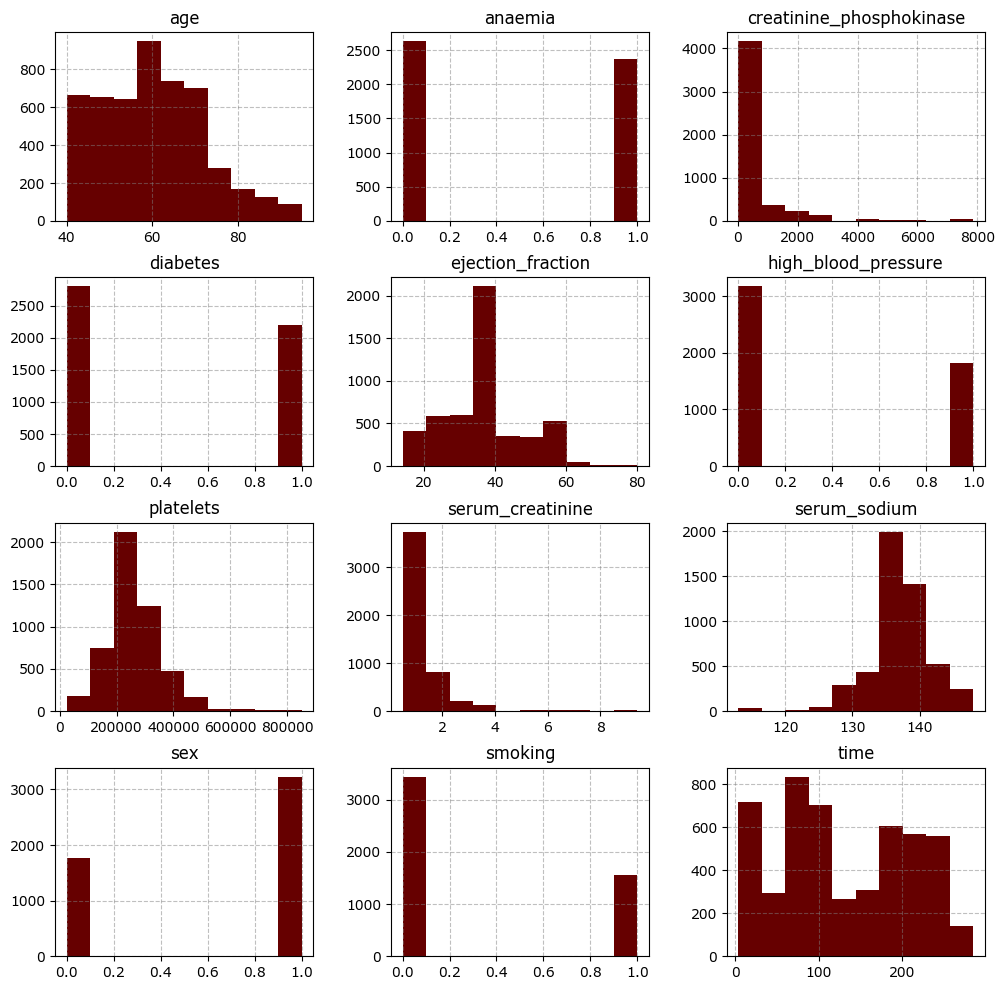

In [4]:
# Plot the histograms of each variable
df[df.columns[:-1]].hist(figsize=(12, 12));

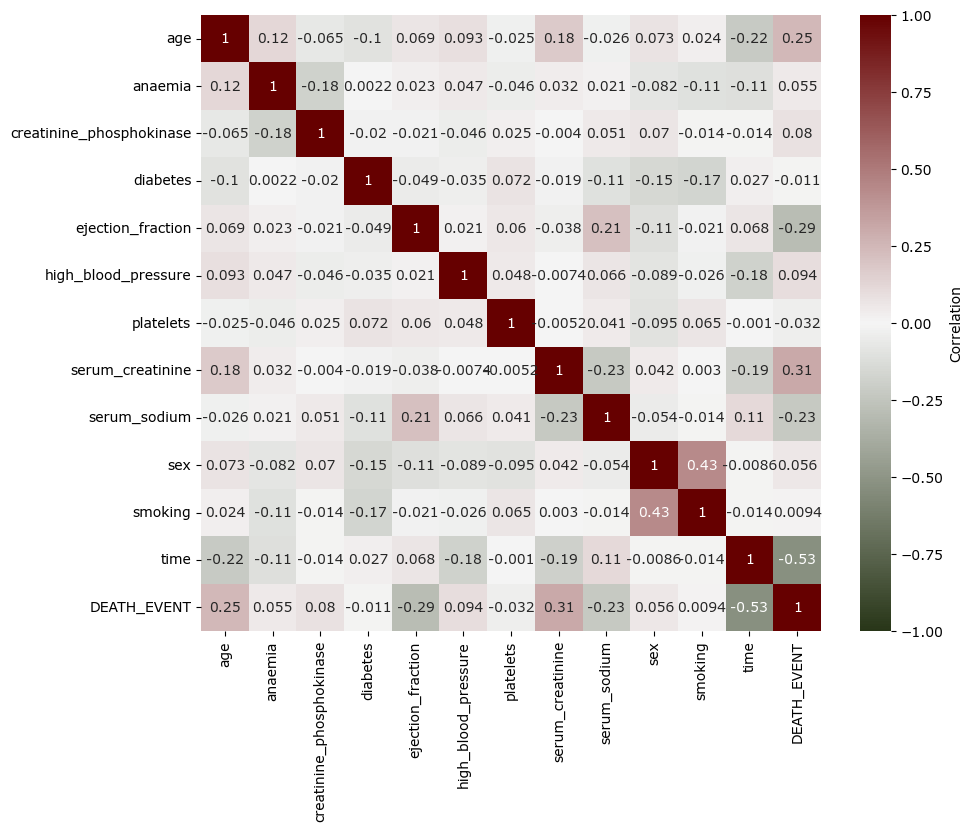

In [5]:
df_corr = df.select_dtypes(include='number').corr(method='pearson')
# Correlation matrix between columns
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='Custom_Seq_Diverging', center=0, vmin=-1, annot=True,
            cbar_kws={'label': 'Correlation'})
plt.grid()

<Figure size 600x200 with 0 Axes>

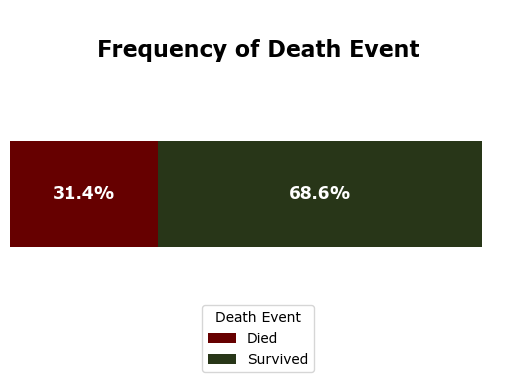

In [79]:
# Plot the distribution of the DEATH_EVENT variable
plt.figure(figsize=(6, 2))  # Reduced vertical length
ax = df["DEATH_EVENT"] \
    .value_counts(normalize=True) \
    .rename({0: "Survived", 1: "Died"}) \
    .reindex(["Died", "Survived"]) \
    .to_frame() \
    .T \
    .plot(kind='barh', stacked=True, width=0.2)

# Annotate the bars with the percentage values
for p in ax.patches:
    width = p.get_width()
    ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
            f'{width * 100:.1f}%', ha='center', va='center', color='white',
            fontsize=12, fontweight='bold')

# Set the figure settings
plt.title("Frequency of Death Event", y=0.85, fontsize=16, fontweight='bold')
plt.legend(title='Death Event', loc='lower center')
plt.axis("off")
plt.show()

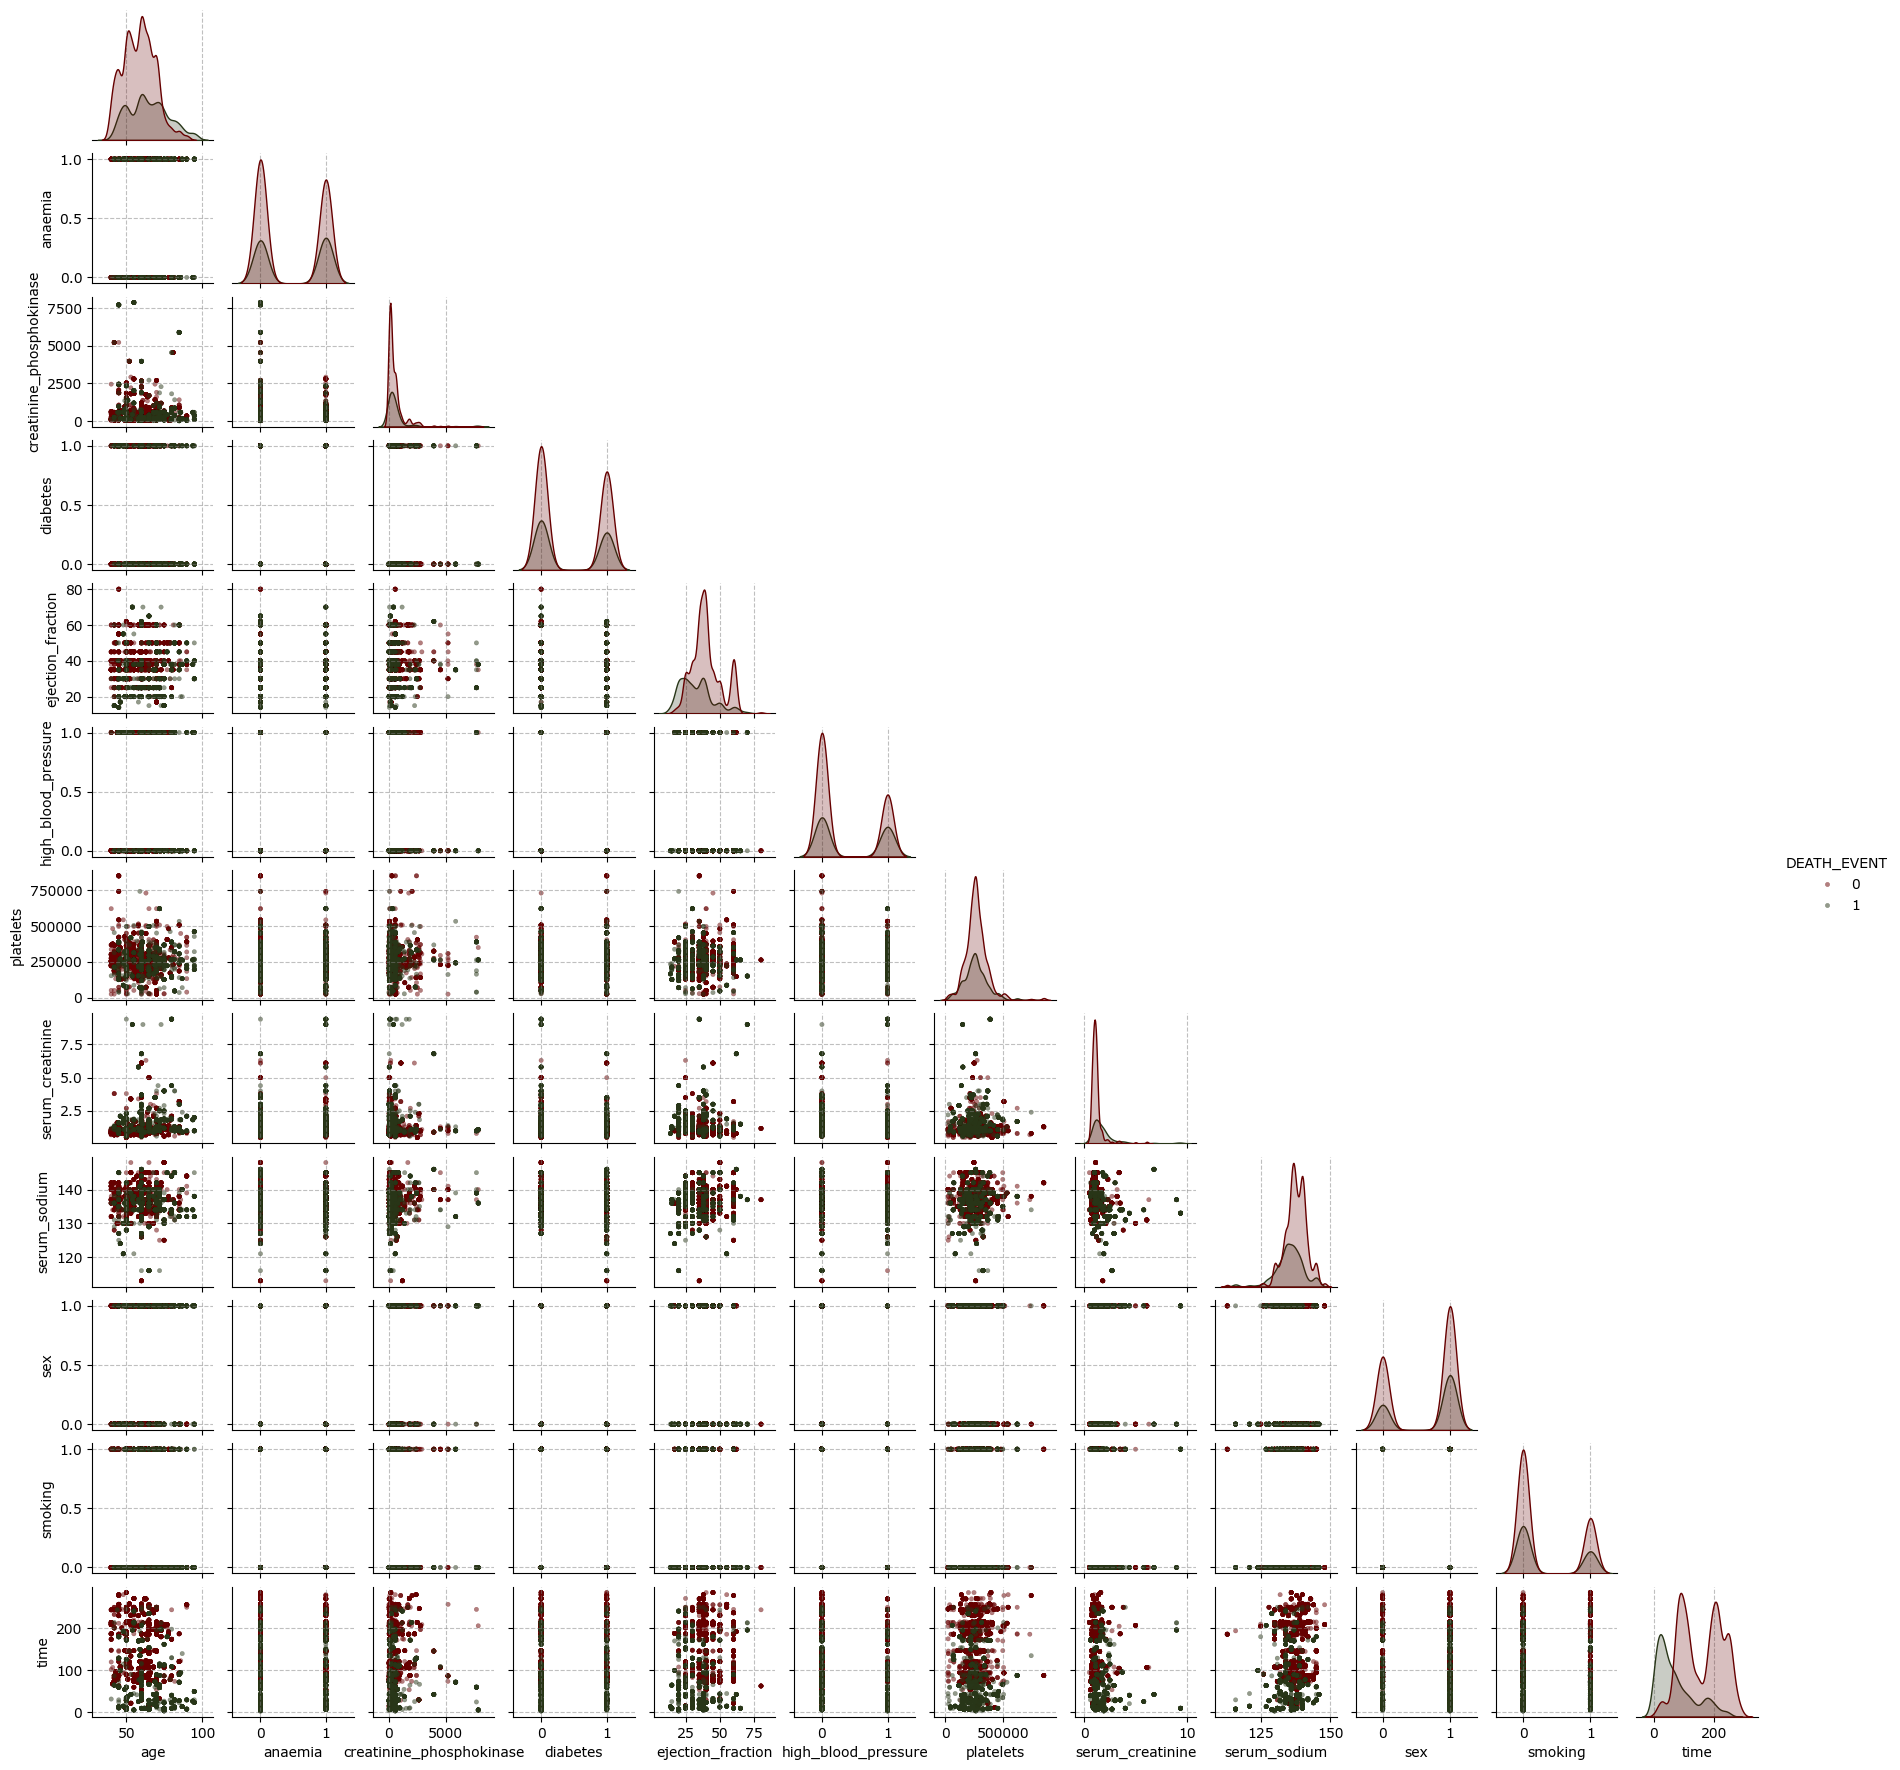

In [81]:
# Sort the dataframe based on 'tsunami' column
df_sorted = df.sort_values(by='DEATH_EVENT')

# Create a pairplot
sns.pairplot(df_sorted.select_dtypes(include='number'), hue='DEATH_EVENT', hue_order=[0, 1],
             corner=True, plot_kws=dict(edgecolor=None, alpha=0.5, s=10), height=1.5);

## 2 - Feature Engineering <a class="anchor" id="feature-engineering-header"></a>

### Split data into train-test sets <a class="anchor" id="split-data-header"></a>

In [82]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X = df.drop(columns='DEATH_EVENT')
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Preprocess the features <a class="anchor" id="prepare-data-header"></a>

In [83]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define custom functions to be applied in the pipeline
def log_scaler(value):
    return np.log(value)

# Define the preprocessing pipelines
log_pipeline = Pipeline([
    ('log_scaler', FunctionTransformer(log_scaler)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])

# Define the columns for the transformations
cols_log_scaler = ['creatinine_phosphokinase', 'platelets']
cols_std_scaler = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']

# Define the full pipeline with all functions
full_pipeline = ColumnTransformer(
    transformers=[
        ("log_pipeline", log_pipeline, cols_log_scaler),
        ("std_scaler", StandardScaler(), cols_std_scaler)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False).set_output(transform='pandas')

# Apply the full pipeline to the training and test sets
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

## 3 - Select and train the best base model <a class="anchor" id="evaluation-header"></a>

In [90]:
from sklearn.metrics import fbeta_score, make_scorer

# Create the F-beta score with beta = 2
fbeta_2_scorer = make_scorer(fbeta_score, beta=2)

In [91]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Try to fit different classifiers to the dataset
clf = LazyClassifier(verbose=False, ignore_warnings=True, custom_metric=None)
# Get the models
models, _ = clf.fit(X_train, X_test, y_train, y_test)

# Create an empty dictionary to store the models and their results
base_models = {}

# Perform K-Fold Cross Validation and get the F2 score for each model
# Define fold number (k) for the cross-validation
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over the models and calculate the F2 score
for model_name, model in clf.models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=fbeta_2_scorer)
    # Store the mean and standard deviation of the F2 score
    base_models[model_name] = (cv_results.mean(), cv_results.std())

# Order the models by their mean F2 score
base_models = dict(sorted(base_models.items(), key=lambda item: item[1][0], reverse=False))

100%|██████████| 31/31 [00:02<00:00, 11.24it/s]


[LightGBM] [Info] Number of positive: 1254, number of negative: 2746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313500 -> initscore=-0.783807
[LightGBM] [Info] Start training from score -0.783807
[LightGBM] [Info] Number of positive: 1003, number of negative: 2197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313437 -> initscore=-0.784097
[LightGBM] [Info] Start training from score -0.784097
[LightGBM] [Info] Nu

Text(0.5, 1.0, 'Performance of Default Models')

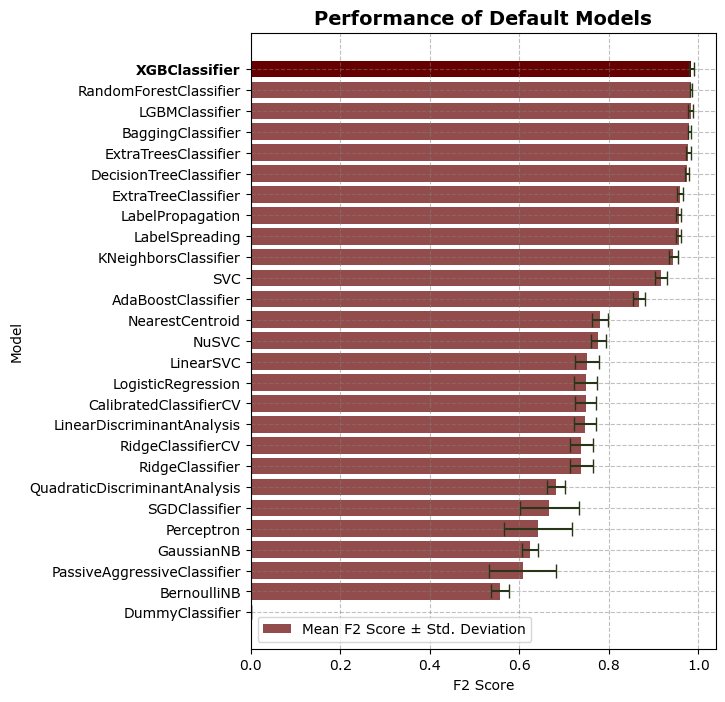

In [92]:
# Extract model names, mean F2 scores, and standard deviations
model_names = list(base_models.keys())
mean_scores = [base_models[name][0] for name in model_names]
std_devs = [base_models[name][1] for name in model_names]

# Identify the best model
best_model_index = mean_scores.index(max(mean_scores))

# Plot the results of the default models
plt.figure(figsize=(6, 8))
for i, (name, score, std) in enumerate(zip(model_names, mean_scores, std_devs)):
    alpha = 1.0 if i == best_model_index else 0.7
    plt.barh(name, score, xerr=std, color=palette[0], capsize=5, error_kw={'ecolor': palette[1]}, alpha=alpha)
# Highlight the best model's y-axis tick label
ax = plt.gca()
for tick_label, tick_position in zip(ax.get_yticklabels(), range(len(model_names))):
    if tick_position == best_model_index:
        tick_label.set_fontweight('bold')  # Set bold for the best model
    else:
        tick_label.set_fontweight('normal')  # Set normal for others
plt.legend(['Mean F2 Score ± Std. Deviation'])
plt.xlabel('F2 Score')
plt.ylabel('Model')
plt.title('Performance of Default Models', fontsize=14, weight='bold')

In [96]:
# Fine-tune the model with GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define a strategy for data splitting
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Define the parameters to search
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "reg_alpha": [0.2, 0.5],
    "reg_lambda": [0.2, 0.5],
    "scale_pos_weight": [1, 2, 5],
}

# Initialize the XGBoost classifier
clf = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid,
                           cv=kfold, scoring=fbeta_2_scorer,
                           n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Initialize the XGBoost classifier with the best parameters
clf = XGBClassifier(random_state=42, **best_params)

# Train the classifier with the training data
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 4 - Evaluate the model <a class="anchor" id="evaluation-header"></a>

In [102]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix heatmap for the given true and predicted values.
    
    Parameters:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        model_name (str): Name of the model to be displayed in the title.
    Returns:
        None: The function saves the confusion matrix plot as a PNG file.
    """
    cf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                    annot=True, cmap='Custom_Red_r', fmt='.1%')
    ax.set_title(f'{model_name}\n',
                fontsize=12, weight='bold')
    ax.set_xlabel('\nActual values', fontsize=10)
    ax.set_ylabel('Predicted values\n', fontsize=10)
    # Change the tick labels from 0 and 1 to 'Survived' and 'Died'
    ax.set_xticklabels(['Survived', 'Died'])
    ax.set_yticklabels(['Survived', 'Died'])

    # Colorbar label ticks
    colorbar = ax.collections[0].colorbar
    ticks = colorbar.ax.get_yticks()
    ticks = [str(int(tick * 100)) + '%' for tick in ticks]
    colorbar.set_ticklabels(ticks)

    plt.grid()

In [98]:
# Predict on the train and test sets
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

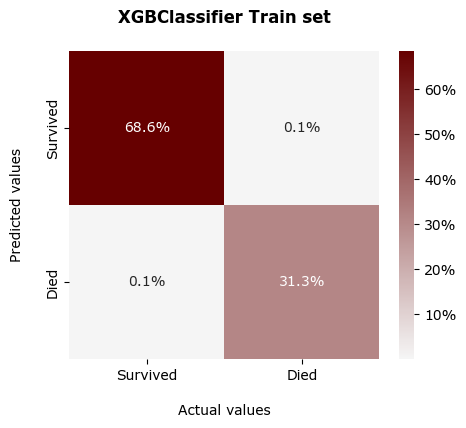

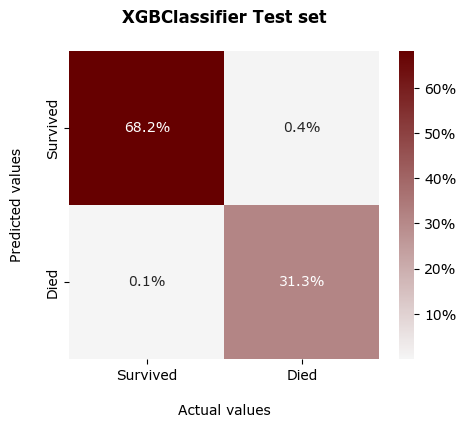

In [103]:
# Plot the confusion matrix for the train set
plot_confusion_matrix(y_train, y_train_pred, clf.__class__.__name__ + " Train set")

# Plot the confusion matrix for the test set
plot_confusion_matrix(y_test, y_test_pred, clf.__class__.__name__ + " Test set")

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# Calculate the metrics for the train and test sets

print('Accuracy:')
print("Train: %.2f" % accuracy_score(y_train, y_train_pred))
print("Test: %.2f" % accuracy_score(y_test, y_test_pred))

print('\nPrecision (tp / (tp + fp)):')
print("Train: %.2f" % precision_score(y_train, y_train_pred))
print("Test: %.2f" % precision_score(y_test, y_test_pred))

print('\nRecall (tp / (tp + fn)):')
print("Train: %.2f" % recall_score(y_train, y_train_pred))
print("Test: %.2f" % recall_score(y_test, y_test_pred))

print('\nF1-Score (2 * (precision * recall) / (precision + recall)):')
print("Train: %.2f" % f1_score(y_train, y_train_pred))
print("Test: %.2f" % f1_score(y_test, y_test_pred))

print('\nFβ-Score (β=2):')
print("Train: %.2f" % fbeta_score(y_train, y_train_pred, beta=2))
print("Test: %.2f" % fbeta_score(y_test, y_test_pred, beta=2))

Accuracy:
Train: 1.00
Test: 0.99

Precision (tp / (tp + fp)):
Train: 1.00
Test: 0.99

Recall (tp / (tp + fn)):
Train: 1.00
Test: 1.00

F1-Score (2 * (precision * recall) / (precision + recall)):
Train: 1.00
Test: 0.99

Fβ-Score (β=2):
Train: 1.00
Test: 0.99


### Calibrate the decision threshold by maximizing the evaluation metric <a class="anchor" id="calibrate-thres-header"></a>

In [106]:
# Define a function to adjust the class predictions based on the threshold and the predicted scores
def adjusted_classes(y_scores, t=None):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    if t is None:
        t = 0.5 # default threshold
    return np.array([1 if y >= t else 0 for y in y_scores])

Text(0.5, 1.0, 'Precision-Recall Curve')

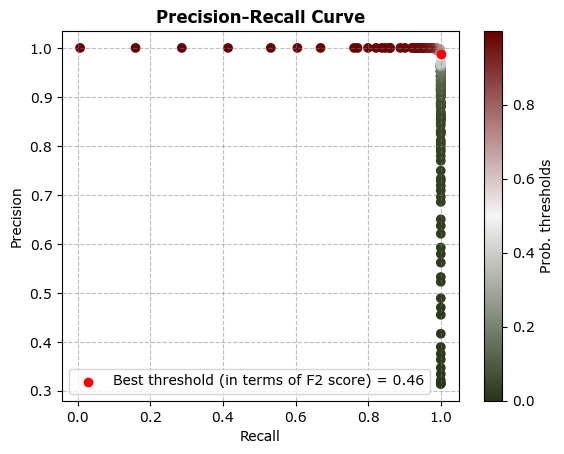

In [108]:
# Find the optimal threshold for binary classification
thresholds = np.arange(0, 1, 0.001) # Define the thresholds
precision_t, recall_t, f2_score_t = [], [], []

# Get the predicted probabilities for positive class
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Compute the precision, recall and Fbeta score for each threshold
for t in thresholds:
    y_pred_t = adjusted_classes(y_pred_prob, t)
    precision_t.append(precision_score(y_test, y_pred_t))
    recall_t.append(recall_score(y_test, y_pred_t))
    f2_score_t.append(fbeta_score(y_test, y_pred_t, beta=2))

# Find the best threshold in terms of Fbeta score
best_thresh = thresholds[np.nanargmax(f2_score_t)]

fig, ax = plt.subplots()
test_scatter = ax.scatter(recall_t, precision_t, c=thresholds, marker='o', cmap='Custom_Seq_Diverging')
cbar = plt.colorbar(test_scatter)
cbar.set_label('Prob. thresholds')
ax.scatter(recall_t[np.nanargmax(f2_score_t)],
           precision_t[np.nanargmax(f2_score_t)],
           marker='o', color='red', label='Best threshold (in terms of F2 score) = %.2f' % (best_thresh), zorder=2)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc='best')
ax.set_title('Precision-Recall Curve', weight='bold')

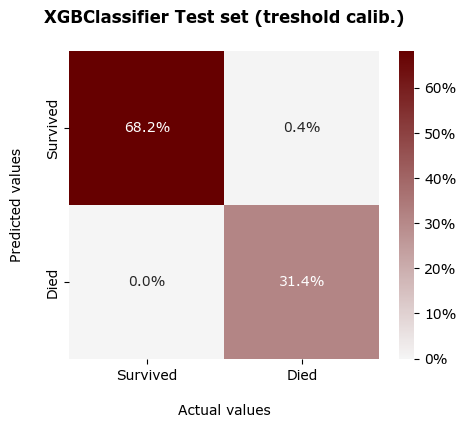

In [109]:
# Plot again the confusion matrix with the new threshold
y_test_pred = adjusted_classes(y_pred_prob, best_thresh)

# Plot the confusion matrix for the test set
plot_confusion_matrix(y_test, y_test_pred, clf.__class__.__name__ + " Test set (treshold calib.)")

In [110]:
# Calculate F2-score for the test set with the new threshold
f2_score_calib = fbeta_score(y_test, y_test_pred, beta=2)
print(f"F2-score for the test set with the new threshold: {f2_score_calib:.2f}")

F2-score for the test set with the new threshold: 1.00


In [111]:
# Compute the probability of the positive class for the train and test sets
# Train set
y_train_prob_df = y_train[y_train == 1].to_frame()
y_train_prob_df["Set"] = "Train"
y_train_prob_df["Model Probability"] = model.predict_proba(X_train)[:, 1][y_train == 1]
# Test set
y_test_prob_df = y_test[y_test == 1].to_frame()
y_test_prob_df["Set"] = "Test"
y_test_prob_df["Model Probability"] = model.predict_proba(X_test)[:, 1][y_test == 1]
# Concatenate the two DataFrames
y_prob_df = pd.concat([y_train_prob_df, y_test_prob_df]).reset_index(drop=True)

Text(0.5, 0.98, 'Model probability distribution for the positive events')

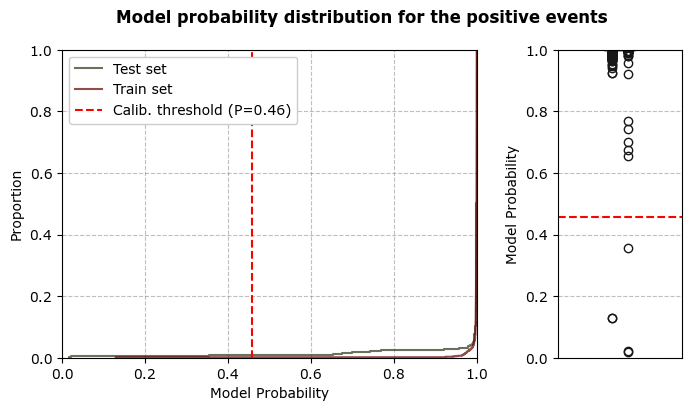

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[1, 0.3])
# ECDF plot
sns.ecdfplot(data=y_prob_df, x="Model Probability",
             hue="Set",
             alpha=0.7, ax=ax[0])
ax[0].axvline(best_thresh, color='r', ls='--')
ax[0].legend(['Test set', 'Train set', f'Calib. threshold (P={best_thresh:.2f})'], loc='upper left', framealpha=1)
ax[0].set_xlim(0, 1)
# Boxplot
sns.boxplot(data=y_prob_df, y="Model Probability",
            hue="Set", width=0.25, ax=ax[1])
ax[1].axhline(best_thresh, color='r', ls='--')
# Remove the x tick
ax[1].set_xticks([])
ax[1].set_ylim(0, 1)
# Remove the legend
ax[1].get_legend().remove()
# Add space between the subplots
plt.subplots_adjust(wspace=0.3)
fig.suptitle('Model probability distribution for the positive events', weight='bold')